# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [88]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [89]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Images

In [90]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [91]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [154]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
count=0
for folder in os.listdir(folder_path):
    count=0
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg") and count<=487:
            count+=1
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)


#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [155]:
#labels_np=np.array(labels)
#selected_indices={}
#classes=['Mild Dementia','Non Demented','Very mild Dementia','Moderate Dementia']
#samples=[600,2000,600,488]
#for n,t in zip(samples,classes):
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],n,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],selected_indices['Moderate Dementia']))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [156]:
#Check the size of the images
data_arr.shape

(3688, 128, 128, 3)

In [157]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [158]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 600
Moderate Dementia: 488
Non Demented: 2000
Very mild Dementia: 600


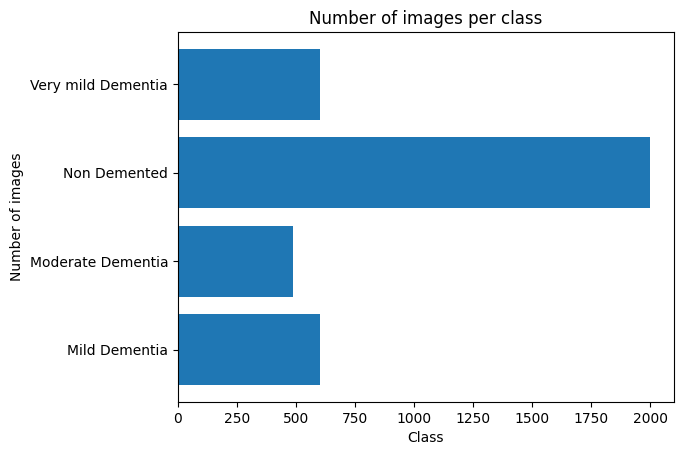

In [159]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

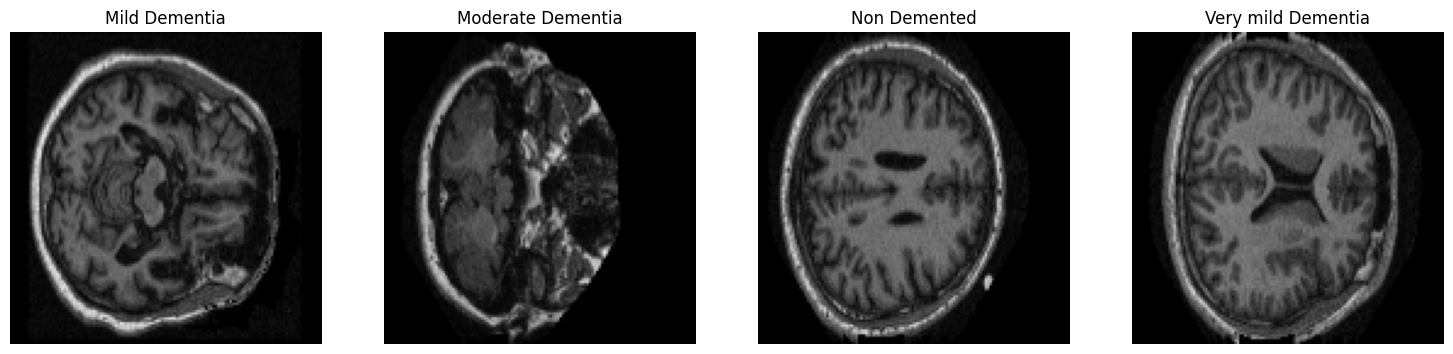

In [160]:

#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,450),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(451,900),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(901,1350),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1351,1800),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [161]:
#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [162]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]#
    #Random left flip
    #image = tf.image.stateless_random_flip_left_right(
    #   image, seed)#
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
    #    image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
    #    image, 0.2, seed)
    #Introduce saturation
    image = tf.image.stateless_random_saturation(
        image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    #image = tf.clip_by_value(image, 0, 255)
    return image

In [163]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [164]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.1)
  return image2/255,image1/255

In [165]:
#Function to prepare the images augmentation
def image_label_wrapper(image,label):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  return image1/255,label

In [166]:
#Mean squared error between 2 images
def mse(image1,image2):
  mse=np.mean((image1.astype('float')-image2.astype('float'))**2)
  return mse

In [167]:
#Mean squared error between 2 groups of images
def mse_mean(image1,image2):
  mse_values=[]
  for n in range(0,image1.shape[0]):
      mse_value = mse(image1[n],image2[n])
      mse_values.append(mse_value)

  mse_mean = np.mean(mse_values)
  return mse_mean

In [168]:
#Peak signal to noise ratio between two groups of images
def psnr_mean(image1,image2):
  psnr_values=[]
  for n in range(0,image1.shape[0]):
    mse1=mse(image1[n],image2[n])
    psnr=20*np.log10(1/np.sqrt(mse1))
    psnr_values.append(psnr)
  psnr_mean = np.mean(psnr_values)
  return psnr_mean

In [169]:
#Structural similarity index between two images
def ssim_mean(image1,image2):
  ssim_values=[]
  for n in range(0,image1.shape[0]):
      ssim_value = ssim(image1[n],image2[n],channel_axis=2,data_range=image1[n].max()-image1[n].min())
      ssim_values.append(ssim_value)
  ssim_mean = np.mean(ssim_values)
  return ssim_mean

In [170]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [171]:
label_encoder=preprocessing.LabelEncoder()
label_encoder.fit(labels)
labels_encoded=label_encoder.transform(labels)
labels_encoded=to_categorical(labels_encoded)

In [172]:
#Split train and test
data_train,data_test,label_train,label_test=model_selection.train_test_split(data_arr,labels_encoded, test_size=0.1, random_state=42,stratify=labels_encoded)
data_train,data_validation,label_train,label_validation=model_selection.train_test_split(data_train,label_train, test_size=0.2, random_state=42,stratify=label_train)

In [77]:
#Preprocess the data for denoising
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(32)

In [25]:
data_validation_noise=np.array([image_noise(x,0.1) for x in data_validation])
data_validation_processed=tf.data.Dataset.from_tensor_slices((data_validation_noise/255,data_validation/255)).batch(32)

data_test_noise=np.array([image_noise(x,0.1) for x in data_test])
data_test_processed=tf.data.Dataset.from_tensor_slices((data_test_noise/255,data_test/255)).batch(32)

KeyboardInterrupt: 

In [173]:
data_train_classification_processed=tf.data.Dataset.from_tensor_slices((data_train,label_train)).shuffle(100).map(image_label_wrapper).batch(32)
data_validation_classification_processed=tf.data.Dataset.from_tensor_slices((data_validation/255,label_validation)).batch(32)
data_test_classification_processed=tf.data.Dataset.from_tensor_slices((data_test/255,label_test)).batch(32)

In [28]:
#Get data preprocessed
data_test_processed

NameError: name 'data_test_processed' is not defined

In [ ]:
#Examples of
for item in data_train_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0][0].numpy())
    ax[0].set_title('Augmented-Noised')
    ax[0].axis('off')
    ax[1].imshow(item[1][0].numpy())
    ax[1].set_title('Original')
    ax[1].axis('off')

In [29]:
test_original = np.asarray(list(data_test_processed.unbatch().map(lambda x, y: y)))

## Denoising

In [ ]:
single_test_original=np.expand_dims(data_arr[1]/255,axis=0)
single_test_noise=np.expand_dims(image_noise(data_arr[1],0.07).numpy()/255,axis=0)

### Autoencoder

In [ ]:
#Basic auto encoder for denoising
#Encoder 1Conv + BatchNorm + MaxPooling
def encoder(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D((2,2),padding='same')(x)
        return x
    return apply

In [ ]:
#Decoder 1ConvTrans + BatchNorm
def decoder(filters):
    def apply(x):
        x=layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#Auto Encoder 3Encoder + 3Decoder from 3 to 128
def autoencoder(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    #Encoder
    x=encoder(32)(inputs)
    x=encoder(64)(x)
    x=encoder(128)(x)
    #Decoder
    x=decoder(128)(x)
    x=decoder(64)(x)
    x=decoder(32)(x)
    outputs=layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [ ]:
#Define autoencoder and see the structure
ae=autoencoder()
ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
#Compile model with adam and mean squared error
ae.compile(optimizer='adam',loss='mse')

In [ ]:
ae_history=ae.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 580ms/step - loss: 0.1187 - val_loss: 0.0766
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - loss: 0.0514 - val_loss: 0.0374
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - loss: 0.0304 - val_loss: 0.0296
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - loss: 0.0192 - val_loss: 0.0307
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0124 - val_loss: 0.0309
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - loss: 0.0087 - val_loss: 0.0280
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0067 - val_loss: 0.0245
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - loss: 0.0055 - val_loss: 0.0205
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0047 - val_loss: 0.0160
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 0.0042 - val_loss: 0.0130


In [ ]:
ae_prediction=ae.predict(single_test_noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(-0.5, 127.5, 127.5, -0.5)

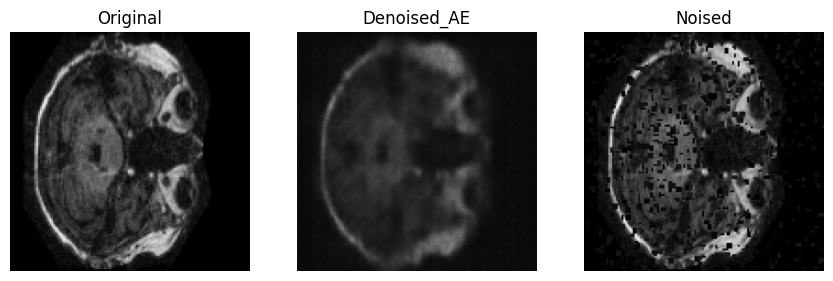

In [ ]:

fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
#fig.suptitle('Auto Encoder denoising',fontsize=16)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ae_prediction[0])
ax[1].set_title('Denoised_AE')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

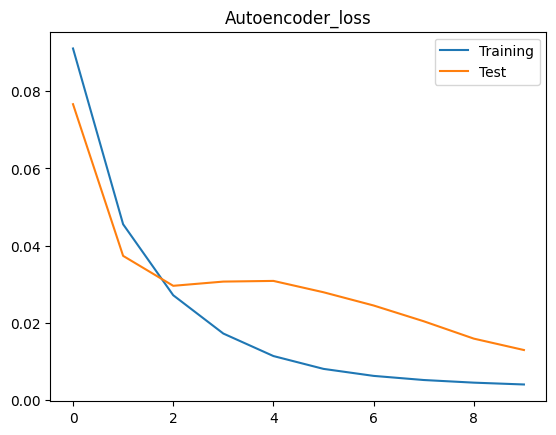

In [ ]:
plt.plot(ae_history.history['loss'],label='Training')
plt.plot(ae_history.history['val_loss'],label='Test')
plt.title('Autoencoder_loss')
plt.legend()
plt.show()

In [ ]:
ae_predicted=ae.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


In [ ]:
ae_mse=mse_mean(test_original,ae_predicted)
ae_psnr=psnr_mean(test_original,ae_predicted)
ae_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(ae_mse,3))
print('PSNR:',round(ae_psnr,3))
print('SSIM:',round(ae_ssim,3))

MSE: 0.013
PSNR: 67.159
SSIM: 0.349


### U-Net

In [ ]:
#U-Net for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#U-Net encoder 1MaxPooling + 1DoubleConv
def unet_encoder(filters):
    def apply(x):
        x=layers.MaxPooling2D((2,2))(x)
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net decoder 1ConvTrans + 1Concatenate +1DoubleConv
def unet_decoder(filters):
    def apply(x, skip):
        x=layers.Conv2DTranspose(filters,(3,3),activation='relu',strides=2,padding='same')(x)
        x=layers.Concatenate()([x, skip])
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net from 3 to 1024 with MaxPooling
def unet(input_shape=(128, 128, 3)):
    input = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_double_conv(64)(input)
    x2 = unet_encoder(128)(x1)
    x3 = unet_encoder(256)(x2)
    x4 = unet_encoder(512)(x3)
    x  = unet_encoder(1024)(x4)
    #Decoder feom 512 to 3
    x = unet_decoder(512)(x, x4)
    x = unet_decoder(256)(x, x3)
    x = unet_decoder(128)(x, x2)
    x = unet_decoder(64)(x, x1)
    output = layers.Conv2D(3,(1,1),activation='sigmoid')(x)
    return models.Model(input,output)

In [ ]:
unet=unet()
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 128, 128, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 128, 128, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 64, 64, 128)    │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64, 64, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 128)    │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 32, 32, 256)    │          1,024 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 34,537,027 (131.75 MB)

 Trainable params: 34,525,251 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
#Compile the unet with adam and mse
unet.compile(optimizer='adam',loss='mse')

In [ ]:
#fit unet with train and validation sets
unet_history=unet.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - loss: 0.0990 - val_loss: 0.0519
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 863ms/step - loss: 0.0301 - val_loss: 0.0389
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 832ms/step - loss: 0.0150 - val_loss: 0.0419
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 841ms/step - loss: 0.0089 - val_loss: 0.0484
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 859ms/step - loss: 0.0056 - val_loss: 0.0492
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - loss: 0.0039 - val_loss: 0.0481
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 833ms/step - loss: 0.0031 - val_loss: 0.0469
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - loss: 0.0024 - val_loss: 0.0433
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 833ms/step - loss: 0.0020 - val_loss: 0.0389
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 858ms/step - loss: 0.0017 - val_loss: 0.0328


In [ ]:
#Predict a single test
unet_predicted=unet.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(-0.5, 127.5, 127.5, -0.5)

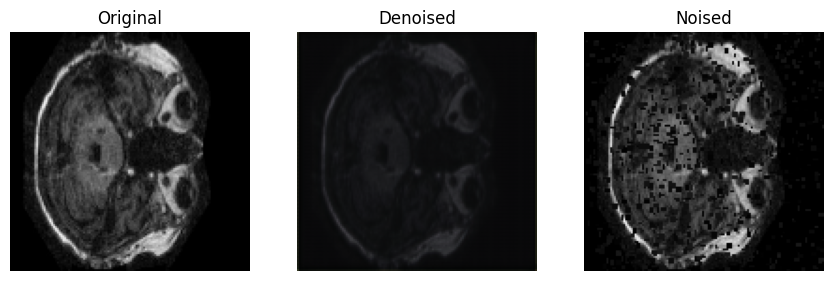

In [ ]:
#Check the first results of the model
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(unet_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

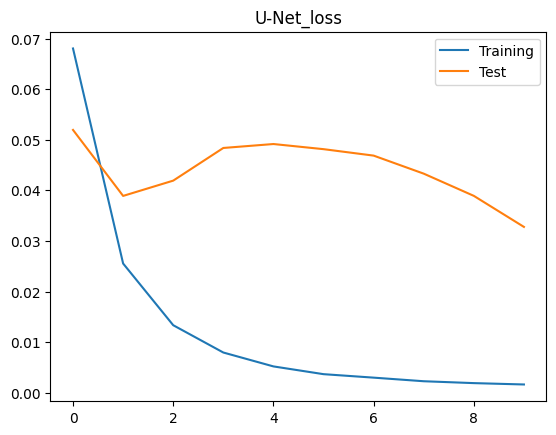

In [ ]:
plt.plot(unet_history.history['loss'],label='Training')
plt.plot(unet_history.history['val_loss'],label='Test')
plt.title('U-Net_loss')
plt.legend()
plt.show()

In [ ]:
unet_predicted=unet.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [ ]:
unet_mse=mse_mean(test_original,unet_predicted)
unet_psnr=psnr_mean(test_original,unet_predicted)
unet_ssim=ssim_mean(test_original,unet_predicted)
print('MSE:',round(unet_mse,3))
print('PSNR:',round(unet_psnr,3))
print('SSIM:',round(unet_ssim,3))

MSE: 0.032
PSNR: 63.18
SSIM: 0.208


### U-Net Residual (Upsampling)

In [ ]:
def unet_conv_res(filters):
    def apply(x):
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(conv)
        conv = layers.BatchNormalization()(conv)

        shortcut=layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
        shortcut = layers.BatchNormalization()(shortcut)

        res = layers.Add()([shortcut, conv])
        res = layers.Activation('relu')(res)
        return res
    return apply

In [ ]:
#U-Net with updampling for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet2_conv(filters):
    def apply(x):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#Unet encoder with 1MaxPoolin and +1DoubleConv
def unet_encoder_res(filters):
    def apply(x):
        x = layers.MaxPooling2D((2,2))(x)
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [ ]:
#Unet decoder with 1Upsampling + 1ConvTrans +1Concat + 1DoubleConv
def unet_decoder_res(filters):
    def apply(x, skip):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Conv2DTranspose(filters, (1,1), activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [ ]:
#U-Net from 3 to 1024 with Upsampling
def unet_res(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_conv_res(64)(inputs)
    x2 = unet_encoder_res(128)(x1)
    x3 = unet_encoder_res(256)(x2)
    x4 = unet_encoder_res(512)(x3)
    x  = unet_encoder_res(1024)(x4)
    #Decoder from 512 to 3
    x = unet_decoder_res(512)(x, x4)
    x = unet_decoder_res(256)(x, x3)
    x = unet_decoder_res(128)(x, x2)
    x = unet_decoder_res(64)(x, x1)
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [ ]:
#U-Net with Upsampling model with summary
unet_res = unet_res()
unet_res.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 128, 128, 64)   │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 64)   │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 128, 128, 64)   │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 128, 128, 64)   │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 64, 64, 128)    │            512 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 128)    │          8,320 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 64, 64, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 30,374,019 (115.87 MB)

 Trainable params: 30,356,355 (115.80 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [ ]:
#U-Net with upsampling compile with adam and mse
unet_res.compile(optimizer='adam',loss='mse')

In [ ]:
unet_res_history=unet_res.fit(data_train_processed,epochs=15,validation_data=data_validation_processed)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 860ms/step - loss: 9.8645e-04 - val_loss: 0.0155
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 836ms/step - loss: 9.3553e-04 - val_loss: 0.0113
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 859ms/step - loss: 9.0690e-04 - val_loss: 0.0090
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 839ms/step - loss: 8.3614e-04 - val_loss: 0.0070
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 834ms/step - loss: 8.2868e-04 - val_loss: 0.0048
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 840ms/step - loss: 7.9069e-04 - val_loss: 0.0032
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 842ms/step - loss: 7.8387e-04 - val_loss: 0.0020
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 852ms/step - loss: 7.6556e-04 - val_loss: 0.0932
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - loss: 0.0039 - val_loss: 0.0514
Epoch 10/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 839ms/step - loss: 0.0015 - val_loss: 0.0573
Epoch 11/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 843ms/step - loss: 0.0012 - val_loss: 0.0349
Epoch 12/

In [ ]:
single_unet_res_predicted=unet_res.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(-0.5, 127.5, 127.5, -0.5)

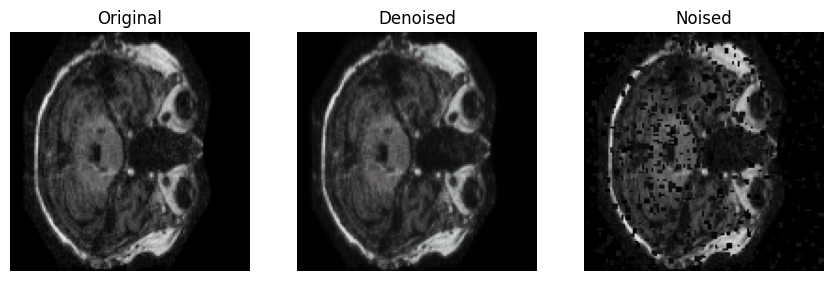

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_unet_res_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

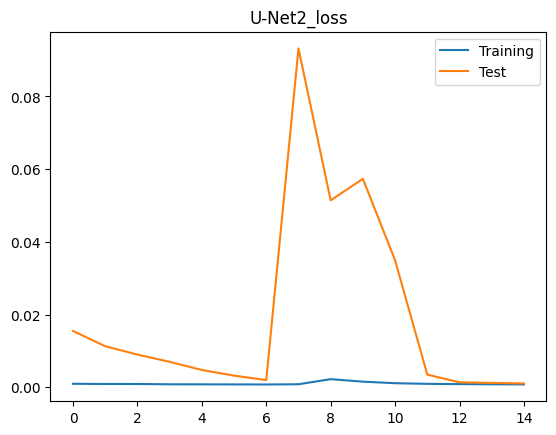

In [ ]:
plt.plot(unet_res_history.history['loss'],label='Training')
plt.plot(unet_res_history.history['val_loss'],label='Test')
plt.title('U-Net2_loss')
plt.legend()
plt.show()

In [ ]:
unet_res_predicted=unet_res.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


In [ ]:
unet_res_mse=mse_mean(test_original,unet_res_predicted)
unet_res_psnr=psnr_mean(test_original,unet_res_predicted)
unet_res_ssim=ssim_mean(test_original,unet_res_predicted)
print('MSE:',round(unet_res_mse,3))
print('PSNR:',round(unet_res_psnr,3))
print('SSIM:',round(unet_res_ssim,3))

MSE: 0.001
PSNR: 29.94
SSIM: 0.903


## Classification

### Transfer learning ResNet50

In [204]:
res_model=tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(128,128,3),pooling='avg')

In [205]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [206]:
res_model.trainable=False

In [207]:
res_transfer=tf.keras.Sequential([
    res_model,
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='softmax')
])

res_transfer.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,153,860 (92.14 MB)

 Trainable params: 562,052 (2.14 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [208]:
res_transfer.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float64)


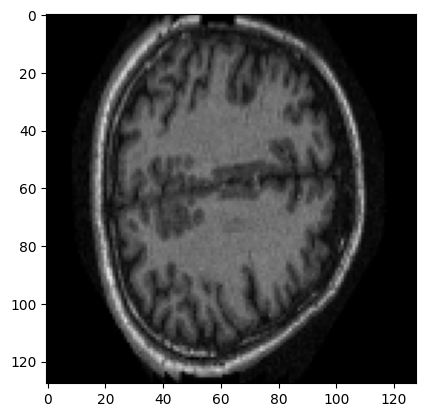

In [209]:
for i in data_train_classification_processed.take(1):
  print(i[1][4])
  plt.imshow(i[0][4])
  break

In [210]:
data_validation_classification_processed

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

In [211]:
res_transfer_history=res_transfer.fit(data_train_classification_processed,epochs=45,validation_data=[data_validation/255,label_validation])#,callbacks=[early_stop,checkpoint,reduce_lr])

Epoch 1/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.5598 - loss: 1.0688 - precision: 0.6888 - recall: 0.3577 - val_accuracy: 0.5346 - val_loss: 1.5401 - val_precision: 0.8305 - val_recall: 0.1476
Epoch 2/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7358 - loss: 0.6539 - precision: 0.8057 - recall: 0.6377 - val_accuracy: 0.4262 - val_loss: 1.4717 - val_precision: 0.6068 - val_recall: 0.1069
Epoch 3/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8014 - loss: 0.5227 - precision: 0.8414 - recall: 0.7406 - val_accuracy: 0.5557 - val_loss: 1.3164 - val_precision: 0.7483 - val_recall: 0.1657
Epoch 4/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8437 - loss: 0.4315 - precision: 0.8711 - recall: 0.8052 - val_accuracy: 0.6295 - val_loss: 0.9225 - val_precision: 0.8480 - val_recall: 0.4202
Epoch 5/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8473 - loss: 0.3855 - precision: 0.8730 - recall: 0.8180 - val_accuracy: 0.7500 - val_loss: 0.687

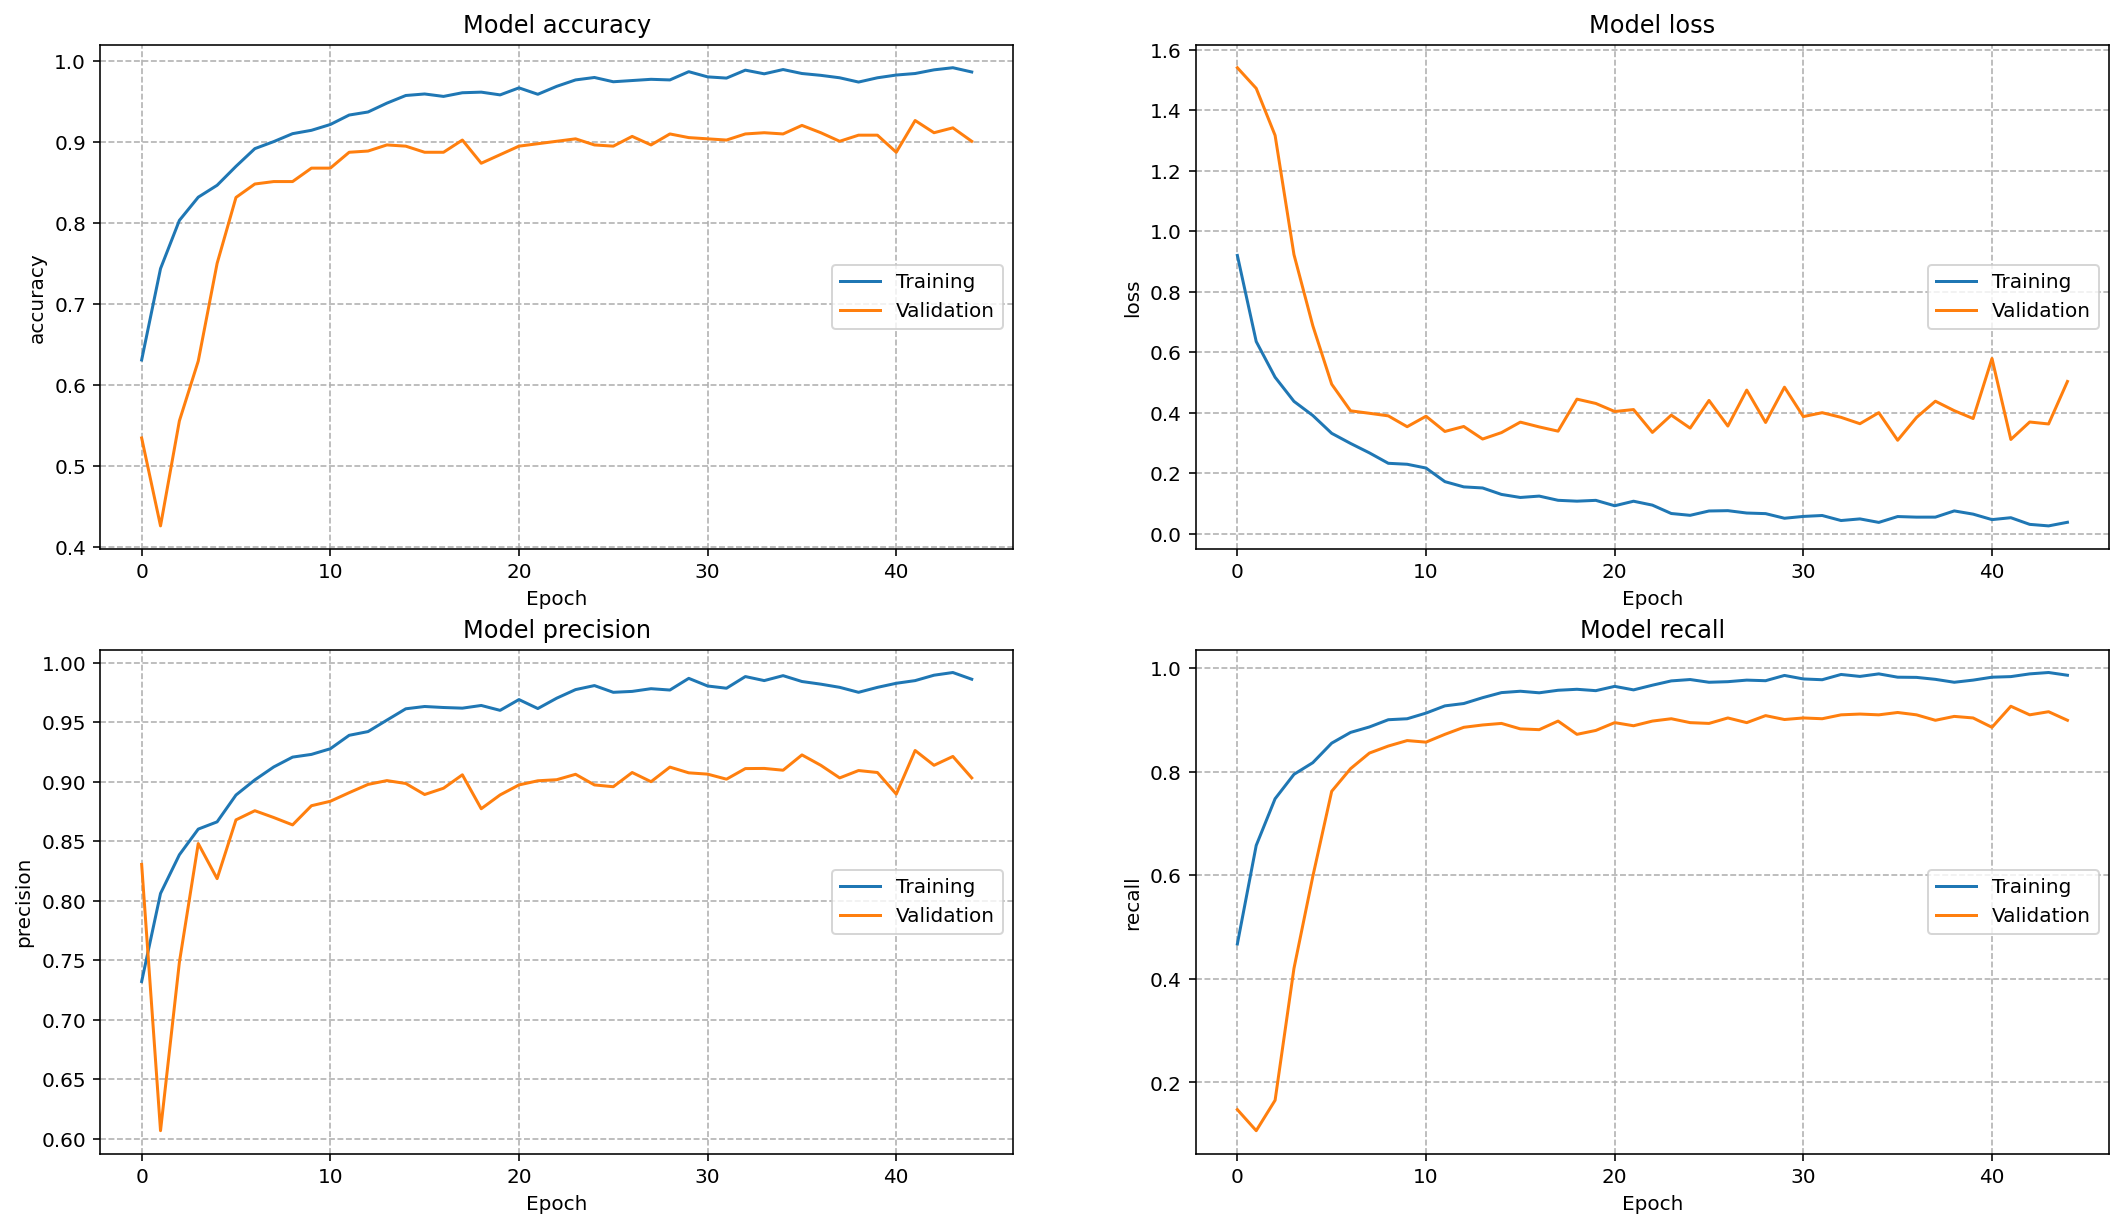

In [212]:
fig, ax = plt.subplots(2, 2, dpi=144, figsize=(18,10))
ax = ax.flatten()
for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(res_transfer_history.history[metric], label='Training')
    ax[i].plot(res_transfer_history.history[f'val_{metric}'], label='Validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend(loc='center right')
    ax[i].grid(linestyle='--', ms=0.5)
plt.show()

In [213]:
res_predicted=res_transfer.predict(data_test/255)
res_predicted=np.argmax(res_predicted,axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step


                    precision    recall  f1-score   support

     Mild Dementia       0.92      0.95      0.93        60
 Moderate Dementia       0.98      1.00      0.99        49
      Non Demented       0.92      0.96      0.94       200
Very mild Dementia       0.88      0.72      0.79        60

          accuracy                           0.92       369
         macro avg       0.92      0.91      0.91       369
      weighted avg       0.92      0.92      0.92       369



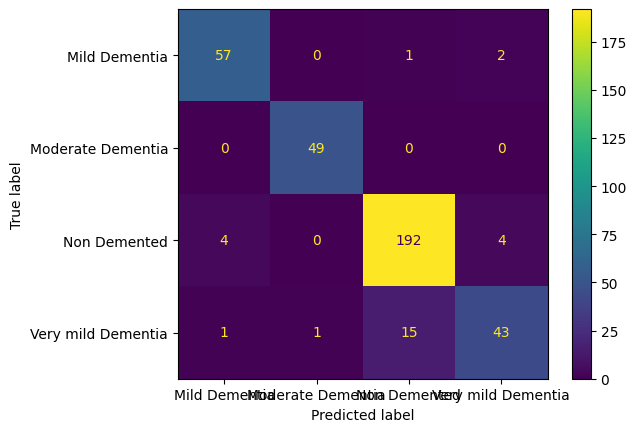

In [214]:
cm=confusion_matrix(np.argmax(label_test,axis=1),res_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()

print(classification_report(np.argmax(label_test,axis=1),res_predicted,target_names=label_encoder.classes_))

### Model 2

In [197]:
model=tf.keras.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='softmax')
])

In [198]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

In [199]:
data_validation_classification_processed

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

In [200]:
model_history=model.fit(data_train_classification_processed,epochs=45,validation_data=[data_validation/255,label_validation])

Epoch 1/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.5196 - loss: 4.8687 - precision: 0.5516 - recall: 0.4702 - val_accuracy: 0.1627 - val_loss: 27.4650 - val_precision: 0.1627 - val_recall: 0.1627
Epoch 2/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7204 - loss: 0.6902 - precision: 0.7901 - recall: 0.6400 - val_accuracy: 0.5151 - val_loss: 14.1807 - val_precision: 0.5151 - val_recall: 0.5151
Epoch 3/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7983 - loss: 0.5193 - precision: 0.8499 - recall: 0.7373 - val_accuracy: 0.5422 - val_loss: 20.3151 - val_precision: 0.5422 - val_recall: 0.5422
Epoch 4/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8399 - loss: 0.4110 - precision: 0.8839 - recall: 0.7958 - val_accuracy: 0.5422 - val_loss: 14.2053 - val_precision: 0.5422 - val_recall: 0.5422
Epoch 5/45
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8503 - loss: 0.3580 - precision: 0.8867 - recall: 0.8203 - val_accuracy: 0.5452 - val_loss: 8

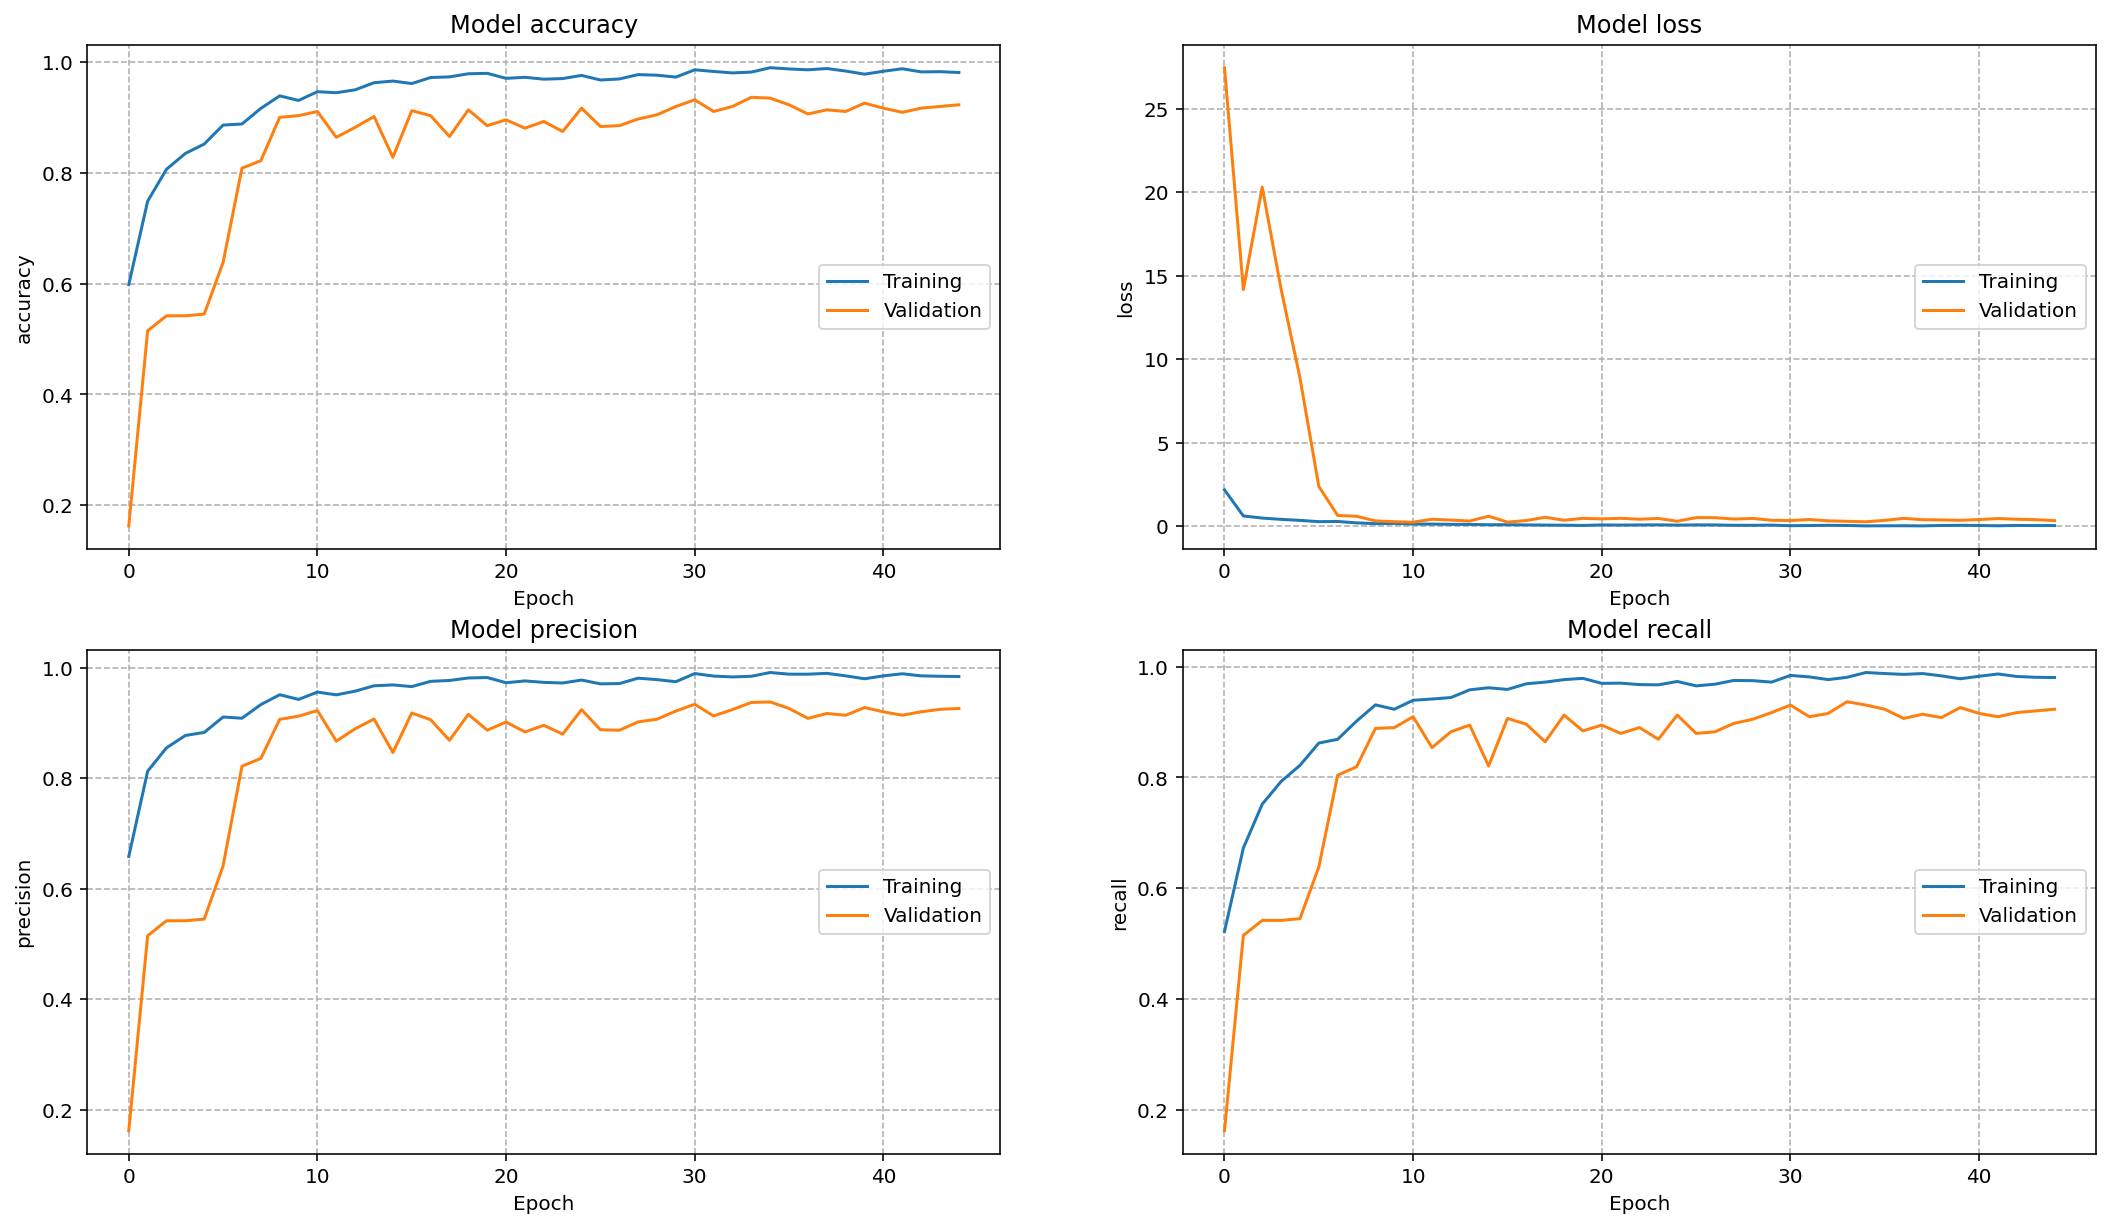

In [201]:
fig, ax = plt.subplots(2, 2, dpi=144, figsize=(18,10))
ax = ax.flatten()
for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(model_history.history[metric], label='Training')
    ax[i].plot(model_history.history[f'val_{metric}'], label='Validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend(loc='center right')
    ax[i].grid(linestyle='--', ms=0.5)
plt.show()

In [202]:
model_predicted=model.predict(data_test/255)
model_predicted=np.argmax(model_predicted,axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


                    precision    recall  f1-score   support

     Mild Dementia       0.97      0.93      0.95        60
 Moderate Dementia       0.98      1.00      0.99        49
      Non Demented       0.91      0.95      0.93       200
Very mild Dementia       0.81      0.72      0.76        60

          accuracy                           0.92       369
         macro avg       0.92      0.90      0.91       369
      weighted avg       0.91      0.92      0.91       369



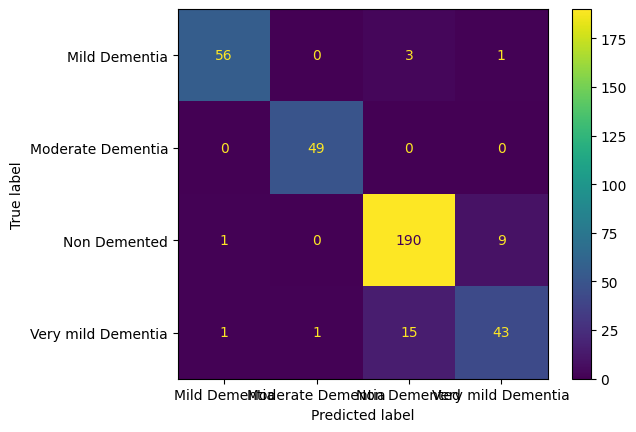

In [203]:
cm=confusion_matrix(np.argmax(label_test,axis=1),model_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()

print(classification_report(np.argmax(label_test,axis=1),model_predicted,target_names=label_encoder.classes_))